
处理数据集: (26064, 299)


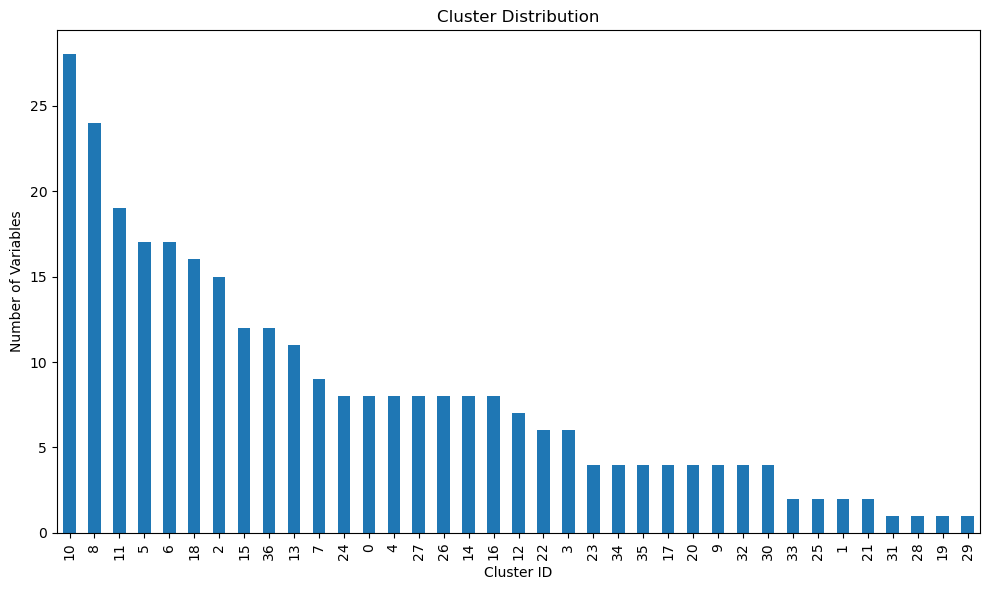


 (° c) temp.
  - Temp. top box (°C)
  - Rotor bearing temp (°C)
  - Rotor bearing temp, Max (°C)
  - Rotor bearing temp, Min (°C)
  - Rotor bearing temp, StdDev (°C)
  - Temp. top box, Max (°C)
  - Temp. top box, Min (°C)
  - Temp. top box, StdDev (°C)

 energy (k wh)
  - Energy Budget - Default (kWh)
  - Energy Theoretical (kWh)

 (° c) temperature,
  - Stator temperature 1 (°C)
  - Nacelle temperature (°C)
  - Hub temperature (°C)
  - CPU temperature (°C)
  - Nacelle temperature, Max (°C)
  - Nacelle temperature, Min (°C)
  - Nacelle temperature, Standard deviation (°C)
  - Hub temperature, min (°C)
  - Hub temperature, max (°C)
  - Hub temperature, standard deviation (°C)
  - CPU temperature, Max (°C)
  - CPU temperature, Min (°C)
  - Stator temperature 1, Max (°C)
  - Stator temperature 1, Min (°C)
  - Stator temperature 1, StdDev (°C)

 factor power (cosphi),
  - Power factor (cosphi)
  - Power factor (cosphi), Max
  - Power factor (cosphi), Min
  - Power factor (cosphi), Standar

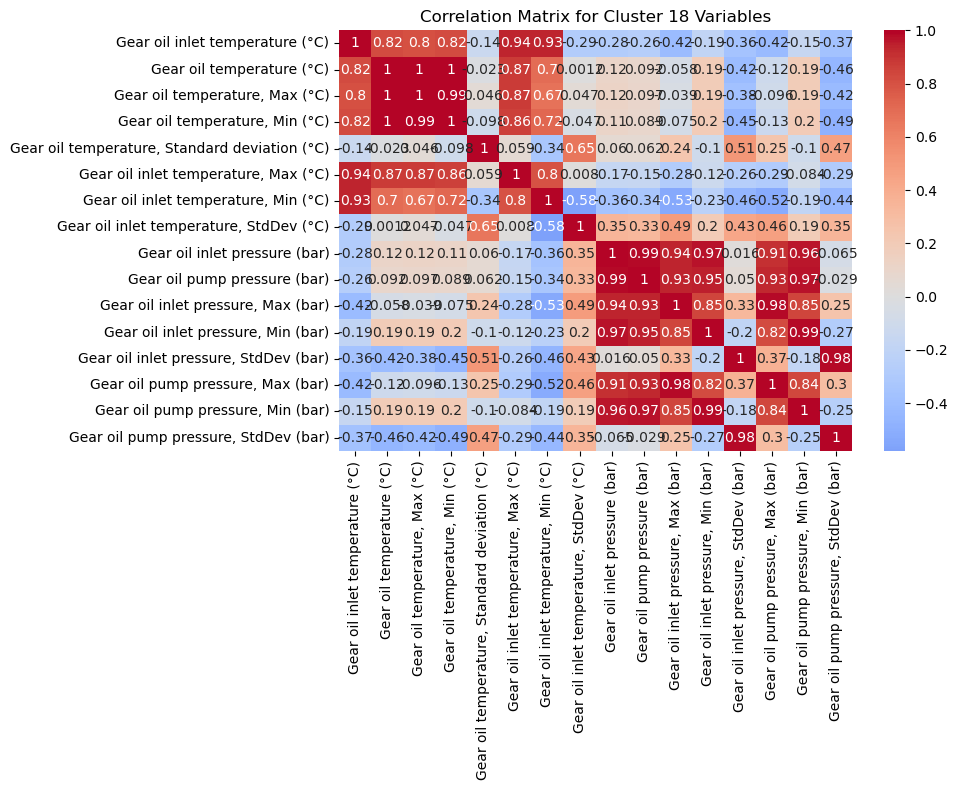


聚类 18 的所有变量的变异系数 (Coefficient of Variation):
  - Gear oil inlet temperature (°C): 0.1958
  - Gear oil temperature (°C): 0.1431
  - Gear oil temperature, Max (°C): 0.1415
  - Gear oil temperature, Min (°C): 0.1452
  - Gear oil temperature, Standard deviation (°C): 1.1700
  - Gear oil inlet temperature, Max (°C): 0.1743
  - Gear oil inlet temperature, Min (°C): 0.2433
  - Gear oil inlet temperature, StdDev (°C): 1.5578
  - Gear oil inlet pressure (bar): 0.5932
  - Gear oil pump pressure (bar): 0.5051
  - Gear oil inlet pressure, Max (bar): 0.5571
  - Gear oil inlet pressure, Min (bar): 0.6527
  - Gear oil inlet pressure, StdDev (bar): 1.7404
  - Gear oil pump pressure, Max (bar): 0.4797
  - Gear oil pump pressure, Min (bar): 0.5548
  - Gear oil pump pressure, StdDev (bar): 1.9620


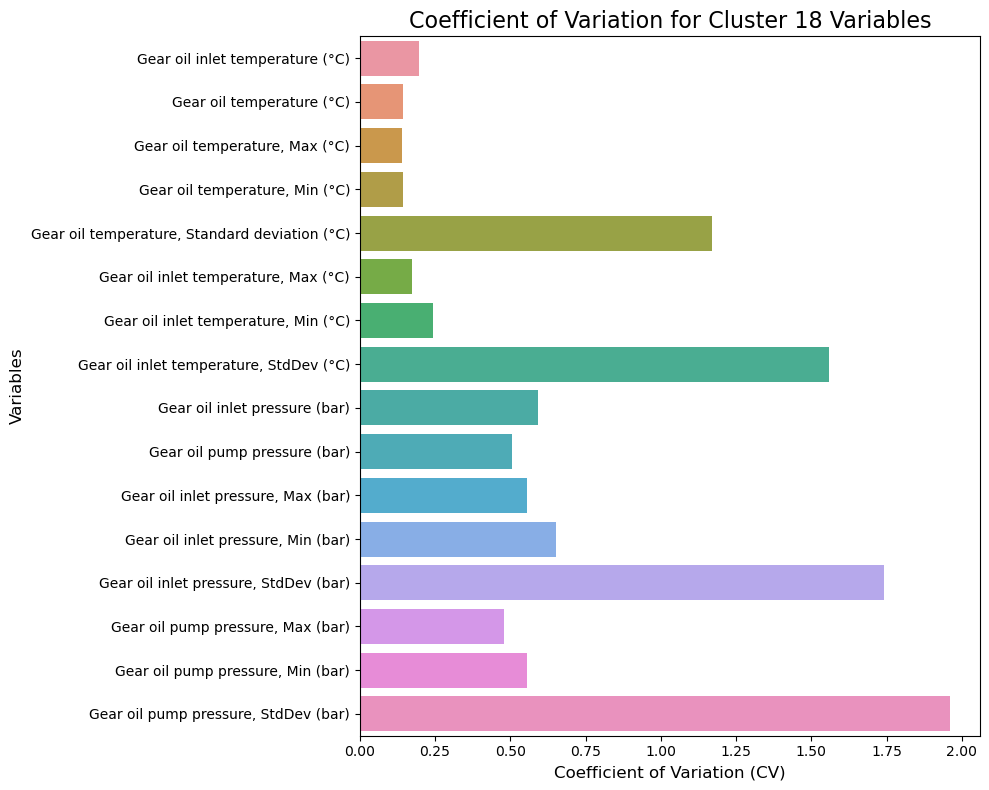

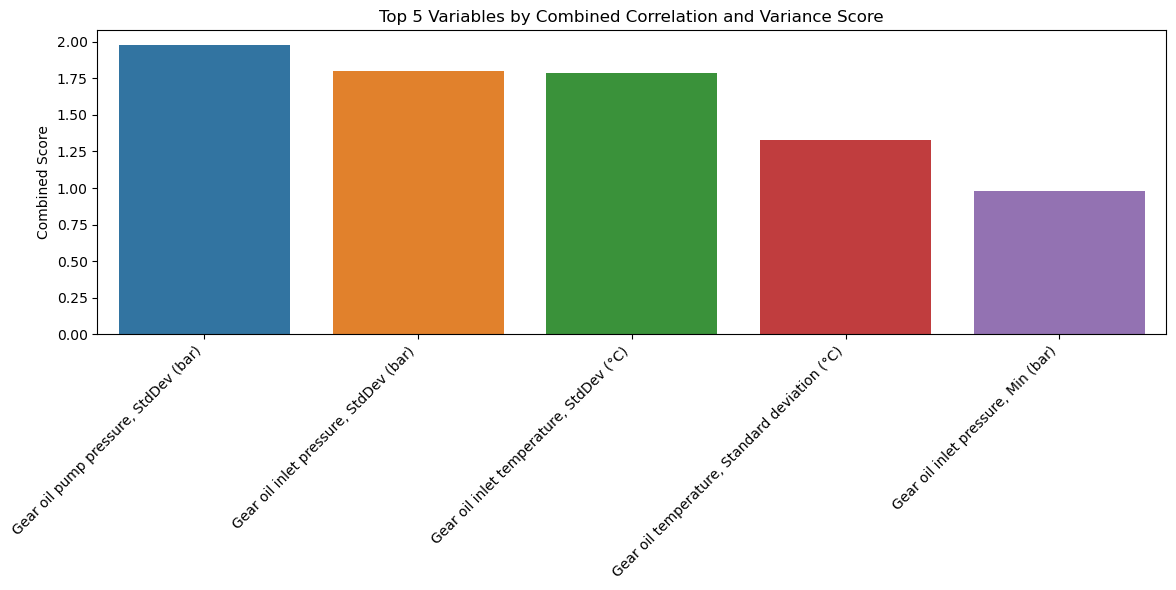


聚类 18 的相关性和方差最高的五个变量为:
  - Gear oil pump pressure, StdDev (bar): 1.9785
  - Gear oil inlet pressure, StdDev (bar): 1.8017
  - Gear oil inlet temperature, StdDev (°C): 1.7833
  - Gear oil temperature, Standard deviation (°C): 1.3290
  - Gear oil inlet pressure, Min (bar): 0.9808


In [ ]:
import pandas as pd
import numpy as np
import re
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import torch
import torch.nn as nn
from torch_geometric.nn import SGConv
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# 创建保存图表的目录
base_output_dir = 'figures'
dataset_turbine = 'Kelmarsh_3'  # 根据文件名提取数据集和风机编号
output_dir = os.path.join(base_output_dir, dataset_turbine)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 数据加载函数
def load_data(turbine_file):
    turbine_df = pd.read_csv(turbine_file, skiprows=9)
    return turbine_df

def split_variable_name(name):
    name = re.sub(r'(?<!^)(?=[A-Z])', ' ', name)
    words = name.lower().split()
    return ' '.join(words)

# 主流程
turbine_file = '../../data/Kel/Turbine_Data_Kelmarsh_3_2021-01-01_-_2021-07-01_230.csv'
turbine_df = load_data(turbine_file)

print(f"\n处理数据集: {turbine_df.shape}")

variable_names = turbine_df.columns
tokenized_names = [split_variable_name(var) for var in variable_names]

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
vectors = vectorizer.fit_transform(tokenized_names).toarray()

cosine_sim = cosine_similarity(vectors)

distance_threshold = 0.85
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold,
                                     metric='precomputed', linkage='average')
clustering.fit(1 - cosine_sim)

labels = clustering.labels_
clustered_vars = pd.DataFrame({'Variable': variable_names, 'Cluster': labels})

# 可视化1：聚类分布柱状图
plt.figure(figsize=(10, 6))
clustered_vars['Cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Variables')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distribution.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

cluster_names = {}
for cluster_id in np.unique(labels):
    cluster_vars = clustered_vars[clustered_vars['Cluster'] == cluster_id]['Variable']
    word_frequency = Counter()
    for var in cluster_vars:
        words = split_variable_name(var).lower().split()
        word_frequency.update(words)
    sorted_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
    cluster_name = ' '.join([word for word, freq in sorted_words[:3]])
    cluster_names[cluster_id] = cluster_name if cluster_name else f'Cluster {cluster_id}'

for cluster_id, cluster_name in cluster_names.items():
    print(f'\n {cluster_name}')
    cluster_vars = clustered_vars[clustered_vars['Cluster'] == cluster_id]['Variable']
    for var in cluster_vars:
        print(f'  - {var}')

cluster_18_vars = clustered_vars[clustered_vars['Cluster'] == 18]['Variable']
df_cluster = turbine_df[cluster_18_vars]

correlation_matrix = df_cluster.corr()

# 可视化2：相关性矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Cluster 18 Variables')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

std_devs = df_cluster.std()
means = df_cluster.mean()
cv = std_devs / means

# 输出聚类 18 的所有变量的变异系数
print("\n聚类 18 的所有变量的变异系数 (Coefficient of Variation):")
for var, cv_value in cv.items():
    print(f"  - {var}: {cv_value:.4f}")

correlation_with_variance = correlation_matrix.mean().abs() + cv
top_5_vars = correlation_with_variance.nlargest(5).index

plt.figure(figsize=(10, 8))
sns.barplot(x=cv.values, y=cv.index)
plt.title('Coefficient of Variation for Cluster 18 Variables', fontsize=16)
plt.xlabel('Coefficient of Variation (CV)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'coefficient_of_variation.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

# 可视化3：综合评分条形图（前 5 名）
plt.figure(figsize=(12, 6))
sns.barplot(x=top_5_vars, y=correlation_with_variance[top_5_vars])
plt.title('Top 5 Variables by Combined Correlation and Variance Score')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Combined Score')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'top_5_variables.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()
plt.close()

print("\n聚类 18 的相关性和方差最高的五个变量为:")
for var in top_5_vars:
    score = correlation_with_variance[var]
    print(f"  - {var}: {score:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import warnings

warnings.filterwarnings('ignore')

# 设置字体
plt.rcParams['font.family'] = 'Times New Roman'

# 创建保存目录
base_output_dir = 'figures'
dataset_turbine = 'Kelmarsh_3'
output_dir = os.path.join(base_output_dir, dataset_turbine)
os.makedirs(output_dir, exist_ok=True)

# 数据加载
def load_data(turbine_file):
    try:
        df = pd.read_csv(turbine_file, skiprows=9)
        print(f"数据加载成功，形状: {df.shape}")
        return df
    except Exception as e:
        print(f"加载失败: {e}")
        return None

# 拆分变量名
def split_variable_name(name):
    name = re.sub(r'(?<!^)(?=[A-Z])', ' ', name)
    return ' '.join(name.lower().split())

# 主程序
turbine_file = '../../data/Kel/Turbine_Data_Kelmarsh_3_2021-01-01_-_2021-07-01_230.csv'
turbine_df = load_data(turbine_file)
if turbine_df is None:
    raise ValueError("无法继续执行：数据加载失败")

# 选择前 50 个变量
variable_names = turbine_df.columns[:50]
tokenized_names = [split_variable_name(var) for var in variable_names]

# TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=300)
vectors = vectorizer.fit_transform(tokenized_names).toarray()
print(f"TF-IDF 向量形状: {vectors.shape}")

# PCA 降维 + t-SNE
pca = PCA(n_components=min(30, vectors.shape[1]))
vectors_reduced = pca.fit_transform(vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=300)
tsne_vectors = tsne.fit_transform(vectors_reduced)

# 相似度 + 聚类
cosine_sim = cosine_similarity(vectors)
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.85,
                                     metric='precomputed', linkage='average')
clustering.fit(1 - cosine_sim)
labels = clustering.labels_
clustered_vars = pd.DataFrame({'Variable': variable_names, 'Cluster': labels})

# t-SNE 图（聚类前）
plt.figure(figsize=(10, 6))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c='blue', alpha=0.6)
plt.title('t-SNE Before Clustering', fontsize=20)
plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'tsne_before_clustering.png'), dpi=150)
plt.show(); plt.close()

# t-SNE 图（聚类后）
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.title('t-SNE After Clustering', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'tsne_after_clustering.png'), dpi=150)
plt.show(); plt.close()

# 聚类分布图
plt.figure(figsize=(10, 6))
clustered_vars['Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Cluster Distribution', fontsize=20)
plt.xlabel('Cluster ID'); plt.ylabel('Number of Variables')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distribution.png'), dpi=150)
plt.show(); plt.close()

# 聚类命名
cluster_names = {}
for cid in np.unique(labels):
    cluster_vars = clustered_vars[clustered_vars['Cluster'] == cid]['Variable']
    word_freq = Counter()
    for var in cluster_vars:
        words = split_variable_name(var).split()
        word_freq.update(words)
    cluster_name = ' '.join([w for w, _ in word_freq.most_common(3)])
    cluster_names[cid] = cluster_name or f'Cluster {cid}'

# 输出各聚类变量
for cid, cname in cluster_names.items():
    print(f"\n{cname}")
    for var in clustered_vars[clustered_vars['Cluster'] == cid]['Variable']:
        print(f"  - {var}")

# 聚类 18 深度分析
if 18 in clustered_vars['Cluster'].values:
    cluster_18_vars = clustered_vars[clustered_vars['Cluster'] == 18]['Variable']
    df_cluster = turbine_df[cluster_18_vars]

    # 相关性热力图（不加注释）
    plt.figure(figsize=(10, 8))
    corr_matrix = df_cluster.corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix for Cluster 18')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'), dpi=150)
    plt.show(); plt.close()

    # 变异系数分析
    means = df_cluster.mean().replace(0, np.nan)
    stds = df_cluster.std()
    cv = (stds / means).fillna(0)

    print("\n变异系数 (Coefficient of Variation):")
    for var, value in cv.items():
        print(f"  - {var}: {value:.4f}")

    # 综合评分 = 相关性平均值 + CV
    combined_score = corr_matrix.mean().abs() + cv
    top_5_vars = combined_score.nlargest(5).index

    # CV 条形图
    plt.figure(figsize=(10, 8))
    sns.barplot(x=cv.values, y=cv.index)
    plt.title('Coefficient of Variation (Cluster 18)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cv_cluster_18.png'), dpi=150)
    plt.show(); plt.close()

    # 综合评分 Top 5
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_5_vars, y=combined_score[top_5_vars])
    plt.title('Top 5 Variables by Combined Score')
    plt.ylabel('Combined Score')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_5_variables.png'), dpi=150)
    plt.show(); plt.close()

    print("\nTop 5 综合得分变量:")
    for var in top_5_vars:
        print(f"  - {var}: {combined_score[var]:.4f}")
else:
    print("\nCluster 18 不存在于前 50 个变量中。")


: 

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import torch.nn.functional as F
from mamba_ssm import Mamba  # Import Mamba module

# 1. SDSGC 定义
class SDSGC(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SDSGC, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # 权重和偏置
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

        # 动态权重调整因子
        self.alpha = nn.Parameter(torch.tensor(1.0))  # 可学习的动态缩放因子

    def forward(self, x, edge_index):
        N = x.size(0)
        device = x.device

        # 构建邻接矩阵
        adj = torch.zeros(N, N, device=device)
        adj[edge_index[0], edge_index[1]] = 1
        adj[edge_index[1], edge_index[0]] = 1

        # 计算度矩阵并归一化
        degree = torch.sum(adj, dim=1)
        degree_inv_sqrt = degree.pow(-0.5)
        degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0
        D_inv_sqrt = torch.diag(degree_inv_sqrt)

        # 计算归一化拉普拉斯矩阵
        I = torch.eye(N, device=device)
        L = I - D_inv_sqrt @ adj @ D_inv_sqrt

        # 图卷积操作，结合动态缩放因子
        x_out = (I + self.alpha * L) @ x @ self.weight + self.bias
        return x_out

# 2. 修改后的模型定义
class DAEG_MambaGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=None, lambda_factor=0.1, dropout=0.2):
        super(DAEG_MambaGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.lambda_factor = lambda_factor
        if output_dim is None:
            output_dim = input_dim

        # 替换 SGConv 为 SDSGC
        self.sgc = SDSGC(input_dim, hidden_dim)

        # Mamba 分支
        self.mamba = Mamba(
            d_model=hidden_dim,
            d_state=32,
            d_conv=4,
            expand=2
        )
        self.mamba_proj = nn.Linear(hidden_dim, hidden_dim * 2)

        # BiGRU 分支
        self.bigru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)

        # 融合层
        self.gate = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fusion_norm = nn.LayerNorm(hidden_dim * 2)

        # 编码器-解码器
        self.fc_encode = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_decode = nn.Linear(hidden_dim, hidden_dim * 2)
        self.gru_decode = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc_out = nn.Linear(hidden_dim * 2, input_dim)

        # 归一化和正则化
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # 对比学习投影头
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def dynamic_feature_enhance(self, x):
        delta_x = x[:, 1:, :] - x[:, :-1, :]
        norm_delta_x = self.layer_norm(delta_x)
        enhanced_x = x.clone()
        enhanced_x[:, 1:, :] += self.lambda_factor * norm_delta_x
        return enhanced_x

    def forward(self, x, edge_index):
        batch_size, seq_len, num_features = x.shape
        device = x.device
        x_flat = x.view(-1, num_features)
        edge_index = edge_index.to(device)

        # 图卷积 (SDSGC)
        sgc_out = self.sgc(x_flat, edge_index)
        x = sgc_out.view(batch_size, seq_len, self.hidden_dim)

        # 动态特征增强
        x = self.dynamic_feature_enhance(x)

        # Mamba 分支
        mamba_out = self.mamba(x)
        mamba_out = self.mamba_proj(mamba_out)
        mamba_out = self.dropout(mamba_out)

        # BiGRU 分支
        h0 = torch.zeros(2, batch_size, self.hidden_dim).to(device)
        gru_out, _ = self.bigru(x, h0)
        gru_out = self.dropout(gru_out)

        # 融合
        gate_input = torch.cat([mamba_out, gru_out], dim=-1)
        gate_weight = torch.sigmoid(self.gate(gate_input))
        fused = gate_weight * mamba_out + (1 - gate_weight) * gru_out
        fused = self.fusion_norm(fused)
        fused = self.dropout(fused)

        # 编码
        context = torch.mean(fused, dim=1)
        encoded = self.fc_encode(context)

        # 解码
        decoded = self.fc_decode(encoded).unsqueeze(1).repeat(1, seq_len, 1)
        h0_decode = torch.zeros(2, batch_size, self.hidden_dim).to(device)
        gru_decode_out, _ = self.gru_decode(decoded, h0_decode)
        reconstructed = self.fc_out(gru_decode_out)

        # 对比学习投影
        z = self.projection_head(encoded)

        return reconstructed, encoded, z, gate_weight

# 3. 数据加载
def load_data(status_file, turbine_file):
    status_df = pd.read_csv(status_file, skiprows=9)
    turbine_df = pd.read_csv(turbine_file, skiprows=9)
    turbine_df['Timestamp'] = pd.to_datetime(turbine_df['# Date and time'], errors='coerce')
    return status_df, turbine_df

# 4. 数据预处理
def preprocess_data(data_df, sequence_length=10, selected_features=None):
    if selected_features is None or len(selected_features) == 0:
        raise ValueError("请提供选择的特征列表")

    data_df = data_df.dropna(subset=selected_features + ['Timestamp'])
    features = data_df[selected_features].values

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    sequences = []
    timestamps = []
    for i in range(len(scaled_features) - sequence_length):
        sequences.append(scaled_features[i:i + sequence_length])
        timestamps.append(data_df['Timestamp'].iloc[i])

    data_tensor = torch.tensor(np.array(sequences), dtype=torch.float32)
    return data_tensor, scaler, features, timestamps

# 5. 创建边
def create_edges(data, threshold=0.7):
    num_features = data.shape[1]
    corr_matrix = np.corrcoef(data, rowvar=False)
    edge_list = np.where(np.abs(corr_matrix) > threshold)
    mask = edge_list[0] != edge_list[1]
    edge_index = np.array([edge_list[0][mask], edge_list[1][mask]])
    return torch.tensor(edge_index, dtype=torch.long)

# 6. 智能采样
def smart_sample_data(df, features, target_samples=20000):
    print("执行智能采样（仅基于变化率）...")
    print(f"清洗后可用的最大样本数: {len(df)}")
    start_time = time.time()
    df = df.dropna(subset=features + ['Timestamp'])
    data = df[features].values

    change_rate = np.abs(np.diff(data, axis=0))
    change_rate = np.pad(change_rate, ((1, 0), (0, 0)), mode='constant')
    change_score = change_rate.mean(axis=1)

    indices = np.argsort(change_score)[::-1][:target_samples]
    indices = np.sort(indices)
    sampled_df = df.iloc[indices]

    print(f"采样数据形状: {sampled_df.shape}, 采样时间: {time.time() - start_time:.2f} 秒")
    return sampled_df

# 7. 生成测试集标签
def generate_labels_from_status(status_df, turbine_df, sequence_length=10):
    status_df['Start'] = pd.to_datetime(status_df['Timestamp start'], errors='coerce')
    status_df['End'] = pd.to_datetime(status_df['Timestamp end'], errors='coerce')
    turbine_df['Timestamp'] = pd.to_datetime(turbine_df['# Date and time'], errors='coerce')

    status_df['Label'] = status_df['Status'].apply(lambda x: 1 if str(x).strip().lower() == 'stop' else 0)
    status_df = status_df.dropna(subset=['Start', 'End'])
    turbine_df = turbine_df.dropna(subset=['Timestamp'])

    turbine_df = turbine_df.sort_values('Timestamp')
    labels = []
    for i in range(len(turbine_df) - sequence_length):
        seq_timestamps = turbine_df['Timestamp'].iloc[i:i + sequence_length]
        seq_label = 0
        for ts in seq_timestamps:
            if ((status_df['Start'] <= ts) & (status_df['End'] >= ts) & (status_df['Label'] == 1)).any():
                seq_label = 1
                break
        labels.append(seq_label)
    return np.array(labels)

# 8. 训练模型
def train_model(model, train_loader, edge_index, epochs=100, lr=0.001, gcl_weight=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_re = nn.MSELoss()
    model.train()
    device = model.device
    edge_index = edge_index.to(device)

    for epoch in range(epochs):
        total_re_loss = 0
        total_gcl_loss = 0
        total_loss = 0

        for sequences in train_loader:
            sequences = sequences[0].to(device)
            optimizer.zero_grad()

            recon, encoded, z, _ = model(sequences, edge_index)
            sequences_aug, edge_index_aug = augment_data(sequences, edge_index)
            recon_aug, encoded_aug, z_aug, _ = model(sequences_aug, edge_index_aug.to(device))

            re_loss = criterion_re(recon, sequences)

            z = nn.functional.normalize(z, dim=1)
            z_aug = nn.functional.normalize(z_aug, dim=1)
            gcl_loss_enc = 1 - torch.mean(torch.sum(z * z_aug, dim=1))

            recon_flat = recon.view(recon.size(0), -1)
            recon_aug_flat = recon_aug.view(recon.size(0), -1)
            recon_flat = nn.functional.normalize(recon_flat, dim=1)
            recon_aug_flat = nn.functional.normalize(recon_aug_flat, dim=1)
            gcl_loss_dec = 1 - torch.mean(torch.sum(recon_flat * recon_aug_flat, dim=1))

            gcl_loss = (gcl_loss_enc + gcl_loss_dec) / 2
            loss = (1 - gcl_weight) * re_loss + gcl_weight * gcl_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_re_loss += re_loss.item()
            total_gcl_loss += gcl_loss.item()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], RE Loss: {total_re_loss / len(train_loader):.6f}, "
                  f"GCL Loss: {total_gcl_loss / len(train_loader):.6f}, Total Loss: {total_loss / len(train_loader):.6f}")

# 9. 数据增强
def augment_data(x, edge_index, drop_prob=0.15):
    x_aug = x.clone()
    mask = torch.rand(x.shape) > drop_prob
    x_aug = x_aug * mask.to(x.device) + torch.randn_like(x_aug) * 0.1 * (~mask).to(x.device)
    edge_mask = torch.rand(edge_index.shape[1]) > drop_prob
    edge_index_aug = edge_index[:, edge_mask]
    return x_aug, edge_index_aug

# 10. 异常检测
def evaluate_anomalies(model, test_loader, edge_index, test_labels, gcl_weight=0.1):
    model.eval()
    device = model.device
    edge_index = edge_index.to(device)
    anomaly_scores = []
    all_reconstructed = []
    all_sequences = []
    feature_anomaly_scores = {feature: [] for feature in selected_features}
    attention_weights_list = []

    with torch.no_grad():
        for sequences in test_loader:
            sequences = sequences[0].to(device)
            sequences_aug, edge_index_aug = augment_data(sequences, edge_index)

            recon, encoded, z, attn_weights = model(sequences, edge_index)
            recon_aug, encoded_aug, z_aug, _ = model(sequences_aug, edge_index_aug.to(device))

            mse = torch.mean((recon - sequences) ** 2, dim=[1, 2])

            z = nn.functional.normalize(z, dim=1)
            z_aug = nn.functional.normalize(z_aug, dim=1)
            gcl_score_enc = 1 - torch.sum(z * z_aug, dim=1)

            recon_flat = recon.view(recon.size(0), -1)
            recon_aug_flat = recon_aug.view(recon.size(0), -1)
            recon_flat = nn.functional.normalize(recon_flat, dim=1)
            recon_aug_flat = nn.functional.normalize(recon_aug_flat, dim=1)
            gcl_score_dec = 1 - torch.sum(recon_flat * recon_aug_flat, dim=1)

            gcl_score = (gcl_score_enc + gcl_score_dec) / 2

            anomaly_score = (1 - gcl_weight) * mse + gcl_weight * gcl_score
            anomaly_scores.extend(anomaly_score.cpu().numpy())

            feature_mse = torch.mean((recon - sequences) ** 2, dim=1)
            for i, feature in enumerate(selected_features):
                feature_anomaly_scores[feature].extend(feature_mse[:, i].cpu().numpy())

            all_reconstructed.append(recon.cpu().numpy())
            all_sequences.append(sequences.cpu().numpy())
            attention_weights_list.append(attn_weights.cpu().numpy())

    anomaly_scores = np.array(anomaly_scores)
    anomaly_scores = (anomaly_scores - anomaly_scores.mean()) / (anomaly_scores.std() + 1e-8)

    for feature in selected_features:
        feature_scores = np.array(feature_anomaly_scores[feature])
        feature_anomaly_scores[feature] = (feature_scores - feature_scores.mean()) / (feature_scores.std() + 1e-8)

    all_reconstructed = np.concatenate(all_reconstructed, axis=0)
    all_sequences = np.concatenate(all_sequences, axis=0)
    attention_weights = np.concatenate(attention_weights_list, axis=0)

    mse = mean_squared_error(all_sequences.flatten(), all_reconstructed.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_sequences.flatten(), all_reconstructed.flatten())

    return anomaly_scores, mse, rmse, mae, all_sequences, all_reconstructed, feature_anomaly_scores, attention_weights

In [ ]:
# 主流程
status_file = '/root/code/data/Kel/Status_Kelmarsh_3_2021-01-01_-_2021-07-01_230.csv'
turbine_file = '/root/code/data/Kel/Turbine_Data_Kelmarsh_3_2021-01-01_-_2021-07-01_230.csv'

status_df, turbine_df = load_data(status_file, turbine_file)
print(f"总数据集数量: {turbine_df.shape[0]}")

# 确保时间戳格式
turbine_df['Timestamp'] = pd.to_datetime(turbine_df['# Date and time'], errors='coerce')
turbine_df = turbine_df.dropna(subset=['Timestamp'])

# 按日期划分训练和测试集
train_start = pd.to_datetime('2021-01-01')
train_end = pd.to_datetime('2021-04-25')
test_start = pd.to_datetime('2021-04-26')
test_end = pd.to_datetime('2021-07-01')

train_df_before = turbine_df[(turbine_df['Timestamp'] >= train_start) & (turbine_df['Timestamp'] <= train_end)]
test_df_before = turbine_df[(turbine_df['Timestamp'] >= test_start) & (turbine_df['Timestamp'] <= test_end)]

print(f"采样前训练集数量 (2021-01-01 to 2021-04-25): {len(train_df_before)}")
print(f"采样前测试集数量 (2021-04-26 to 2021-07-01): {len(test_df_before)}")

# 注意：确保 top_5_vars 已定义
selected_features = top_5_vars.tolist()  # 请确保 top_5_vars 已定义
print(f"选择的特征 (Cluster 18 前 5): {selected_features}")

# 智能采样
sampled_df = smart_sample_data(turbine_df, selected_features, target_samples=26064)

# 重新划分采样后的数据
train_df = sampled_df[(sampled_df['Timestamp'] >= train_start) & (sampled_df['Timestamp'] <= train_end)]
test_df = sampled_df[(sampled_df['Timestamp'] >= test_start) & (sampled_df['Timestamp'] <= test_end)]

print(f"采样后训练集数量 (2021-01-01 to 2021-04-25): {len(train_df)}")
print(f"采样后测试集数量 (2021-04-26 to 2021-07-01): {len(test_df)}")

# 数据预处理
sequence_length = 10
train_data_tensor, train_scaler, train_raw_features, _ = preprocess_data(train_df, sequence_length, selected_features)
train_dataset = TensorDataset(train_data_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_data_tensor, test_scaler, test_raw_features, test_timestamps = preprocess_data(test_df, sequence_length, selected_features)
test_dataset = TensorDataset(test_data_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 创建边
edge_index = create_edges(train_raw_features, threshold=0.7)

# 初始化模型
input_dim = train_data_tensor.shape[2]
hidden_dim = 128
output_dim = input_dim
model = DAEG_MambaGRU(input_dim, hidden_dim, output_dim, lambda_factor=0.1, dropout=0.2)
model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(model.device)

总数据集数量: 26064
采样前训练集数量 (2021-01-01 to 2021-04-25): 16417
采样前测试集数量 (2021-04-26 to 2021-07-01): 9504
选择的特征 (Cluster 18 前 5): ['Gear oil pump pressure, StdDev (bar)', 'Gear oil inlet pressure, StdDev (bar)', 'Gear oil inlet temperature, StdDev (°C)', 'Gear oil temperature, Standard deviation (°C)', 'Gear oil inlet pressure, Min (bar)']
执行智能采样（仅基于变化率）...
清洗后可用的最大样本数: 26064
采样数据形状: (23820, 300), 采样时间: 0.03 秒
采样后训练集数量 (2021-01-01 to 2021-04-25): 16367
采样后测试集数量 (2021-04-26 to 2021-07-01): 7345


DAEG_MambaGRU(
  (sgc): SDSGC()
  (mamba): Mamba(
    (in_proj): Linear(in_features=128, out_features=512, bias=False)
    (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
    (act): SiLU()
    (x_proj): Linear(in_features=256, out_features=72, bias=False)
    (dt_proj): Linear(in_features=8, out_features=256, bias=True)
    (out_proj): Linear(in_features=256, out_features=128, bias=False)
  )
  (mamba_proj): Linear(in_features=128, out_features=256, bias=True)
  (bigru): GRU(128, 128, batch_first=True, bidirectional=True)
  (gate): Linear(in_features=512, out_features=256, bias=True)
  (fusion_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc_encode): Linear(in_features=256, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=256, bias=True)
  (gru_decode): GRU(256, 128, batch_first=True, bidirectional=True)
  (fc_out): Linear(in_features=256, out_features=5, bias=True)
  (layer_norm): LayerNorm((128,), e

In [ ]:
# 训练模型
train_model(model, train_loader, edge_index, epochs=100, lr=0.001, gcl_weight=0.3)

总数据集数量: 26064
采样前训练集数量 (2021-01-01 to 2021-04-25): 16417
采样前测试集数量 (2021-04-26 to 2021-07-01): 9504
选择的特征 (Cluster 18 前 5): ['Gear oil pump pressure, StdDev (bar)', 'Gear oil inlet pressure, StdDev (bar)', 'Gear oil inlet temperature, StdDev (°C)', 'Gear oil temperature, Standard deviation (°C)', 'Gear oil inlet pressure, Min (bar)']
执行智能采样（仅基于变化率）...
清洗后可用的最大样本数: 26064
采样数据形状: (23820, 300), 采样时间: 0.14 秒
采样后训练集数量 (2021-01-01 to 2021-04-25): 16367
采样后测试集数量 (2021-04-26 to 2021-07-01): 7345
Epoch [10/100], RE Loss: 0.074977, GCL Loss: 0.015892, Total Loss: 0.057251
Epoch [20/100], RE Loss: 0.031854, GCL Loss: 0.014932, Total Loss: 0.026778
Epoch [30/100], RE Loss: 0.020549, GCL Loss: 0.014300, Total Loss: 0.018675
Epoch [40/100], RE Loss: 0.014478, GCL Loss: 0.013622, Total Loss: 0.014221
Epoch [50/100], RE Loss: 0.013706, GCL Loss: 0.013196, Total Loss: 0.013553
Epoch [60/100], RE Loss: 0.011020, GCL Loss: 0.012503, Total Loss: 0.011465
Epoch [70/100], RE Loss: 0.009688, GCL Loss: 0.01157

In [ ]:
# 保存模型参数
model_save_dir = os.path.join(base_output_dir, dataset_turbine, 'models')
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'K3.pth')
torch.save(model.state_dict(), model_save_path)
print(f"模型参数已保存至: {model_save_path}")

模型参数已保存至: figures/Kelmarsh_3/models/K3.pth


In [ ]:
# Evaluate Model
# 加载模型
model.load_state_dict(torch.load('figures/Kelmarsh_3/models/K3.pth'))
model.to(model.device)
model.eval()

test_labels = generate_labels_from_status(status_df, test_df, sequence_length)
print(f"测试集标签形状: {test_labels.shape}, 异常比例 (Stop): {test_labels.mean():.2f}")

anomaly_scores, mse, rmse, mae, all_sequences, all_reconstructed, feature_anomaly_scores, attention_weights = evaluate_anomalies(
    model, test_loader, edge_index, test_labels, gcl_weight=0.3
)
print(f"异常检测结果 - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

/tmp/ipykernel_524/3329504596.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('figures/Kelmarsh_3/models/K3.pth'))
/tmp/ipykernel_524/14

测试集标签形状: (7335,), 异常比例 (Stop): 0.04
异常检测结果 - MSE: 0.0172, RMSE: 0.1311, MAE: 0.0934
